In [1]:
# Change the dataset in global_vars.py to NAKO.

from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
import ants
import numpy as np

# import skimage
# import skimage.exposure

%load_ext autoreload
%autoreload 2

NAKO_Extreme_Cases = {
    'skinniest': '100043',
    'fattest': '100081',
    'shortest': '100146', 
    'tallest': '100133'
}

vol_to_check_list =  ['100006']
exclude = []
one_time_n4_optimization = True

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/NAKO'))
data_dir

'/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI'

In [3]:
# ' '.join(os.listdir(f'{data_dir}/'))

In [4]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**[1,2,3].nii.gz') # **_2**
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**[1,2,3]_e2.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**[1,2,3].nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**[1,2,3].nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [5]:
file_paths = load_nako_file_paths()

In [6]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

{
    "100006": {
        "LABEL_PATHS": [
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd"
        ],
        "VOLUME_PATHS": {
            "F": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006

In [7]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [8]:
print(n4_dict)

{}


In [9]:
from __future__ import print_function

import SimpleITK as sitk
import sys
import os

# if len(sys.argv) < 2:
#     print("Usage: N4BiasFieldCorrection inputImage " +
#           "outputImage [shrinkFactor] [maskImage] [numberOfIterations] " +
#           "[numberOfFittingLevels]")
#     sys.exit(1)

def SITK_N4_normalization(in_input_file, opp_file, output_file, shrink_factor=3,
                          mask=None, iteration=500, fittingLevel=4, tolerance=1e-03,
                          spline_param=200):
    inputImage = sitk.ReadImage(in_input_file, sitk.sitkFloat32)
    oppImage = sitk.ReadImage(opp_file, sitk.sitkFloat32)
    image = inputImage
#     if len(sys.argv) > 4:
#         maskImage = sitk.ReadImage(sys.argv[4], sitk.sitkUint8)
#     else:
    maskImage = sitk.OtsuThreshold(inputImage, 0, 1,200)

    if shrink_factor != None:
        image = sitk.Shrink(inputImage,
                                 [int(shrink_factor)] * inputImage.GetDimension())
        maskImage = sitk.Shrink(maskImage,
                                [int(shrink_factor)] * inputImage.GetDimension())

    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    
    numberFittingLevels = 4

    if fittingLevel != None:
        numberFittingLevels = int(fittingLevel)

    if iteration != None:
        corrector.SetMaximumNumberOfIterations([int(iteration)]
                                               * numberFittingLevels)
#     corrector.SetNumberOfControlPoints([5,5,6])
#     corrector.SetSplineOrder(3)
    corrector.SetConvergenceThreshold(tolerance)
    
    output = corrector.Execute(image, maskImage)
#     sitk.WriteImage(output, output_file)

    log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)

    output = inputImage / sitk.Exp( log_bias_field )
#     return log_bias_field
    sitk.WriteImage(output, output_file)
    print('done')
    return output_file
#     if ("SITK_NOSHOW" not in os.environ):
#         sitk.Show(output, "N4 Corrected")

In [10]:
def antspy_n4_normalization(in_input_file, opp_file, output_file, shrink_factor=3,
                            mask=False, iteration=500, fittingLevel=4, tolerance=1e-03,
                            spline_param=200):
    img = nb.load(in_input_file)
    data = img.get_fdata()
    
    if mask:
        mask = data.copy()
        mask[data>100] = 1
        mask[data<=100] = 0
        mask_ant_img = ants.from_numpy(mask)
    else:
        mask_ant_img = None
        
    data_ants_img = ants.from_numpy(data, origin=None, spacing=None, direction=None, has_components=False, is_rgb=False)
    
    image_n4 = ants.n4_bias_field_correction(data_ants_img, 
                                  mask=mask_ant_img,
                                  shrink_factor=shrink_factor,
                                  convergence={'iters': [iteration]*4, 'tol': tolerance}, 
                                  spline_param=400, 
                                  verbose=True, 
                                  weight_mask=None)

    image_n4_numpy = image_n4.numpy()
    n4_image = nb.Nifti1Image(image_n4_numpy, img.affine, img.header)
    nb.save(n4_image, output_file)
    
#     opp_img = nb.load(opp_file)
#     opp_data = opp_img.get_fdata()
#     biasfield = data/image_n4_numpy
#     opp_n4 = opp_data/biasfield

#     n4_image = nb.Nifti1Image(opp_n4, opp_img.affine, opp_img.header)
#     nb.save(n4_image, output_file)
    print('done')
    return output_file

In [11]:
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):#enumerate(file_paths[vol]['VOLUME_PATHS']['IN']):
        
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
#         output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_antspy.nii.gz'
#         print(idx, in_file)
#         antspy_n4_normalization(in_file, opp_file, output_file)
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        
#         img = nb.load(in_file)
#         data = img.get_fdata()
#         mask = data.copy()
#         mask[data>100] = 1
#         mask[data<=100] = 0
        
#         data_ants_img = ants.from_numpy(data, origin=None, spacing=None, direction=None, has_components=False, is_rgb=False)
#         mask_ant_img = ants.from_numpy(mask)
#         image_n4 = ants.n4_bias_field_correction(data_ants_img, 
#                                       mask=mask_ant_img,
#                                       shrink_factor=3,
#                                       convergence={'iters': [500, 500, 500, 500], 'tol': 1e-03}, 
#                                       spline_param=400, 
#                                       verbose=True, 
#                                       weight_mask=None)
        
#         image_n4_numpy = image_n4.numpy()
#         opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
#         opp_img = nb.load(opp_file)
#         opp_data = opp_img.get_fdata()
#         biasfield = data/image_n4_numpy
#         opp_n4 = opp_data/biasfield
        
#         n4_image = nb.Nifti1Image(opp_n4, img.affine, img.header)
#         new_filename = opp_file.split('/')[-1].split('.')[0]
#         SITK_N4_normalization(in_file, opp_file, f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected.nii.gz')
#         nb.save(n4_image, f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected.nii.gz')
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file
        
    file_paths[vol]['N4_1'] = n4_dict[vol]

In [12]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

{
    "100006": {
        "LABEL_PATHS": [
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd"
        ],
        "VOLUME_PATHS": {
            "F": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006

In [13]:
# path = file_paths['100036']['VOLUME_PATHS']['IN'][0]
# print(path)
# img = nb.load(path)
# data = img.get_fdata()

# mask = data.copy()
# mask[data>100] = 1
# mask[data<=100] = 0
# mask_img = nb.Nifti1Image(mask, img.affine, img.header)
# print(img.header, mask_img.header)
# file_path = f'{n4_corrected_data_dir}/vol/100036/mask.nii.gz'
# nb.save(mask_img, file_path)

# for i in range(data.shape[0]):
#     plt.plot(data[i])
#     plt.show()
#     plt.imshow(data[i])
#     plt.show()
#     plt.imshow(mask[i])
#     plt.show()

In [14]:
# !pip install ants
# import ants

# data_ants_img = ants.from_numpy(data, origin=None, spacing=None, direction=None, has_components=False, is_rgb=False)
# mask_ant_img = ants.from_numpy(mask)
# image_n4 = ants.n4_bias_field_correction(data_ants_img, 
#                               mask=None,
#                               shrink_factor=3,
#                               convergence={'iters': [500, 500, 500, 500], 'tol': 1e-03}, 
#                               spline_param=400, 
#                               verbose=True, 
#                               weight_mask=None)

# print(image_n4.shape)

In [15]:
# print(type(image_n4.numpy()))

In [16]:
# nb.save(nb.)

# n4_image = nb.Nifti1Image(image_n4.numpy(), img.affine, img.header)
# # print(img.header, mask_img.header)
# file_path = f'{n4_corrected_data_dir}/vol/100036/n4_img_no_mask.nii.gz'
# nb.save(n4_image, file_path)

In [17]:
# # TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

# for vol in file_paths.keys():
#     if one_time_n4_optimization:
#         break
#     if vol_to_check_list is not None and vol not in vol_to_check_list:
#         continue
#     print(f'applying n4 bias field on opp scans of {vol}...')
#     vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
#     idx = 0
#     file_paths[vol]['N4_1'] = []
#     for opp_img, bias_field_img, opp_file in vol_parts:
#         file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
#         idx+=1
# #         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [18]:
# !pip uninstall scikit-image

In [19]:
def multi_vol_stitching_intensify(images, is_label=False):
    if len(images) == 1:
        return images[0]
    elif len(images) == 0:
        raise Exception("Empty Image List!")

    images_sorted = sorted(images, key=lambda im: im.header['qoffset_z'], reverse=True)
    img_0 = images_sorted[0]

    mode = 'nearest' if is_label else 'constant'
    img_0 = resample_to_output(img_0, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#     img_0 = intensity_correction(img_0)

    for idx, img_1 in enumerate(images_sorted[1:]):
        print(f'{idx}th img for syes..  titching...')
        img_1 = resample_to_output(img_1, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
        target_affine = img_0.affine.copy()
        target_affine[2, 3] = img_1.affine[2, 3].copy()
        target_shape = img_0.shape[:2] + img_1.shape[2:]
        img_1 = resample_from_to(img_1, [target_shape, target_affine])
#         img_1 = intensity_correction(img_1)
        later = True if idx == 1 else False
        img_0 = vol_stitching_intensify(img_0, img_1, later)
    return img_0

def intensity_correction(img, is_matrix=False):
    data = img.get_fdata() if not is_matrix else img
    
    print(data.min(), data.max())
    data = skimage.exposure.rescale_intensity(data, in_range=(data.min(), data.max()), out_range=(0, 255))
#     print(data.min(), data.max())
#     data = skimage.exposure.adjust_gamma(data, gamma=1.5)

#     data = skimage.exposure.adjust_log(data, 1)
    
    if is_matrix:
        return data
    else:
        return nb.Nifti1Image(data, img.affine, img.header)

    
def vol_stitching_intensify(im_0, im_1, later=False):
    im_0_z = im_0.shape[2]
    im_1_z = im_1.shape[2]

    # calculate overlap region:
    im_0_end = im_0.header['qoffset_z']
    im_1_end = im_1.header['qoffset_z']

    spacing = im_0.header['pixdim'][3]

    im_0_width = im_0_z * spacing
    im_1_width = im_1_z * spacing

    im_1_start = im_1_end + im_1_width
    im_0_start = im_0_end + im_0_width

    overlap = abs(im_0_end - im_1_start)

    overlap_v = int(round(overlap / spacing))
    extra_overlap = 0
    new_im_dim = abs(round((abs(im_1_end - im_0_start)) / spacing))

    new_img = np.empty([im_0.shape[0], im_0.shape[1], int(new_im_dim)])

    intensity_ref_img = new_img.copy()
    
    im_0_data = im_0.get_fdata()
    im_1_data = im_1.get_fdata()
    overlap_v += extra_overlap
    sigmoid_c = sigmoid(np.linspace(-DEFAULT_LINSPACE, DEFAULT_LINSPACE, overlap_v))
    
    for l in range(0, overlap_v):
        intensity_ref_img[:, :, (im_1_z - overlap_v + l)] = \
            (1 - sigmoid_c[l]) * im_1_data[:, :, (im_1_z - overlap_v) + l] + (sigmoid_c[l]) * im_0_data[:, :, l]
    
    intensity_ref_img = intensity_ref_img[:, :, im_1_z - overlap_v+2:im_1_z-2]
    
    ref_img = nb.Nifti1Image(intensity_ref_img, im_1.affine, im_1.header)
#     nb.save(ref_img, f'temp/ref{later}.nii.gz')
    if later:
        im_1_data = intensity_matching(im_1_data, intensity_ref_img) 
#         im_1_data = skimage.exposure.match_histograms(im_1_data, intensity_ref_img)
    else:
        im_0_data = intensity_matching(im_0_data, intensity_ref_img) 
#         im_0_data = skimage.exposure.match_histograms(im_0_data, intensity_ref_img)
    
    print(new_img.shape, im_0_z, im_1_z, overlap_v)
    overlap_v -= extra_overlap
    
    new_img[:, :, 0:(im_1_z - overlap_v -extra_overlap//2)] = im_1_data[:, :, 0:(im_1_z - overlap_v-extra_overlap//2)]
    new_img[:, :, im_1_z+extra_overlap//2:] = im_0_data[:, :, overlap_v+extra_overlap//2:]
    # overlap region:
    overlap_v += extra_overlap
    for l in range(0, overlap_v):
        new_img[:, :, (im_1_z - overlap_v + l)] = \
            (1 - sigmoid_c[l]) * im_1_data[:, :, (im_1_z - overlap_v) + l] + (sigmoid_c[l]) * im_0_data[:, :, l]
    overlap_v -= extra_overlap
    stitched_img = nb.Nifti1Image(new_img, im_1.affine, im_1.header)
    return stitched_img


def hist_match(img_data, ref_data):
#     template_file = nb.load(histogram_matching_reference_path)
    template = ref_data #template_file.get_fdata()
    volume = img_data
    oldshape = volume.shape
    source = volume.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def intensity_matching(img_data, ref_data):
#     return img_data
    volume = img_data
    template = ref_data
    m_i = np.mean(volume)
    m_r = np.mean(template)
    s_i = np.std(volume)
    s_r = np.std(template)
    hist_mapped_volume = (volume - m_i) * s_r / s_i + m_r
    return hist_mapped_volume # nb.Nifti1Image(hist_mapped_volume, img.affine, img.header)

In [20]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching_intensify(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

# 192 - 62

started with 100006...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -447.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -639.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -867.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0th img for syes..  titching...
(226, 184, 160) 96 96 32
1t

In [21]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 100006...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.         0.         0.      -203.59375]
 [   0.         2.         0.      -178.90625]
 [   0.         0.         3.      -867.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (226, 184, 236)
Transforming Images to RAS.....
-116.251953125
neagtive value detected
saving directory: temp/NAKO/n4_corrected_2/vol/100006


In [22]:
n4_dict[vol]['N4_2']['SCALED']

'temp/NAKO/n4_corrected_2/vol/100006/IN_ras_stitched_n4_scaled.nii.gz'

In [23]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

{
    "100006": {
        "LABEL_PATHS": [
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd"
        ],
        "ONE": {
            "F": "temp/NAKO/n4_corrected_2/vol/100006/F_ras_stitched.nii.gz",
            "IN": "temp/NAKO/n4_corre

In [32]:
for vol in file_paths.keys():
#     if one_time_n4_optimization:
#         break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
#     for idx, opp_file in enumerate(file_paths[vol]['VOLUME_PATHS']['OPP']):
    in_file = n4_dict[vol]['N4_2']['SCALED'] #file_paths[vol]['ONE']['IN']
    print(in_file)
#     img = nb.load(in_file)
#     data = img.get_fdata()
#     mask = data.copy()
#     mask[data>100] = 1
#     mask[data<=100] = 0

#     data_ants_img = ants.from_numpy(data, origin=None, spacing=None, direction=None, has_components=False, is_rgb=False)
#     mask_ant_img = ants.from_numpy(mask)
#     image_n4 = ants.n4_bias_field_correction(data_ants_img, 
#                                   mask=mask_ant_img,
#                                   shrink_factor=3,
#                                   convergence={'iters': [500, 500, 500, 500], 'tol': 1e-03}, 
#                                   spline_param=400, 
#                                   verbose=True, 
#                                   weight_mask=None)

#     image_n4_numpy = image_n4.numpy()
    
    opp_file = file_paths[vol]['ONE']['OPP']
    
#     opp_img = nb.load(opp_file)
#     opp_data = opp_img.get_fdata()
#     biasfield = data/image_n4_numpy
#     opp_n4 = opp_data/biasfield
    
#     n4_image = nb.Nifti1Image(opp_n4, img.affine, img.header)
    new_filename = opp_file.split('/')[-1].split('.')[0]
#     nb.save(n4_image, f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected.nii.gz')
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk_once.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
#     antspy_n4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

n4-biasfield-correction starting with 100006...
temp/NAKO/n4_corrected_2/vol/100006/IN_ras_stitched_n4_scaled.nii.gz
done


In [25]:
# # TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
# for vol in file_paths.keys():
#     if vol_to_check_list is not None and vol not in vol_to_check_list:
#         continue
#     print(f'applying n4 bias field on stitched opp scans of {vol}...')

#     opp_file = file_paths[vol]['ONE']['OPP']
    
#     n4_counterpart = n4_dict[vol]['N4_2']
#     print(opp_file, n4_counterpart['IN_BIAS'])
#     opp_img = read_ras(opp_file)
#     bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

#     file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [26]:
with open('nako_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [27]:
with open('nako_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)
    
print(json.dumps(file_paths, indent=4))

{
    "100006": {
        "VOLUME_PATHS": {
            "OPP": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz"
            ],
            "IN": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_1_e2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_2_e2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_3_e2.nii.gz"
            ],
            "F": [
                "/home/ab

In [28]:
def nako_vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))

    label_affine = label.affine
    vol_affine = vol.affine
    if(vol_vol>label_vol):
#         final_label = np.zeros(vol.shape)
        target_affine = vol_affine
        target_header = vol.header
        target_dim_v = vol.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(label_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
        print(sx,sy,sz,ex,ey,ez)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = vol, final_label_img
    else:
#         final_label = np.zeros(label.shape)
        target_affine = label_affine
        target_header = label.header
        target_dim_v = label.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(vol_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(vol, label))
        print(sx,sy,sz,ex,ey,ez)
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = vol.get_fdata()
        
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = final_label_img, label
    
    return volume, label

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])##np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100006
['datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d

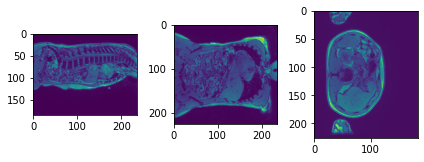

Affine:[[   2.         0.         0.      -203.59375]
 [   0.         2.         0.      -178.90625]
 [   0.         0.         3.      -867.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (226, 184, 236)


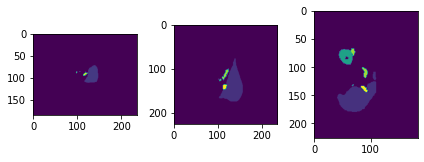

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.


In [29]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
#     volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
    s_label = label_parts(img_ras_list)
    volume, s_label = nako_vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


100006


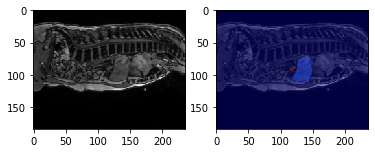

In [30]:
visualize_overlay(file_paths)


In [31]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }